# Lane Line Detection
The goal from this project is to detect the lane of a moving car using classical (not deep learning) computer vision approach

In [1]:
#import libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
from moviepy.editor import VideoFileClip
%matplotlib inline

## Camera Calibration
First we have to calibrate the camera, to do so we have some chess board images that we use to get the distortion factors of the camera

In [2]:
def distortion_factors():
    # Prepare object points
    # From the provided calibration images, 9*6 corners are identified 
    nx = 9
    ny = 6
    objpoints = []
    imgpoints = []
    # Object points are real world points, here a 3D coordinates matrix is generated
    # z coordinates are 0 and x, y are equidistant as it is known that the chessboard is made of identical squares
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
  
    # Make a list of calibration images
    os.listdir("camera_cal/")
    cal_img_list = os.listdir("camera_cal/")  
    
    # Imagepoints are the coresspondant object points with their coordinates in the distorted image
    # They are found in the image using the Open CV 'findChessboardCorners' function
    for image_name in cal_img_list:
        import_from = 'camera_cal/' + image_name
        img = cv2.imread(import_from)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # If found, draw corners
        if ret == True:
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            imgpoints.append(corners)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    for image_name in cal_img_list:
        import_from = 'camera_cal/' + image_name
        img = cv2.imread(import_from)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # If found, draw corners
        if ret == True:
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

            undist = cv2.undistort(img, mtx, dist, None, mtx)
            export_to = 'camera_cal_undistorted/' + image_name
            # save the image in the destination folder
            plt.imsave(export_to, undist)
    return mtx, dist

In [3]:
distortion_factors()

(array([[1.15777930e+03, 0.00000000e+00, 6.67111054e+02],
        [0.00000000e+00, 1.15282291e+03, 3.86128937e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-0.24688775, -0.02373133, -0.00109842,  0.00035108, -0.00258571]]))

## Perspective
The next step is to use the distortion factor to transform from car camera to bird eye view, this is done by choosing straight line lanes and say that these lines instead of meeting at the horizon should be parallel.
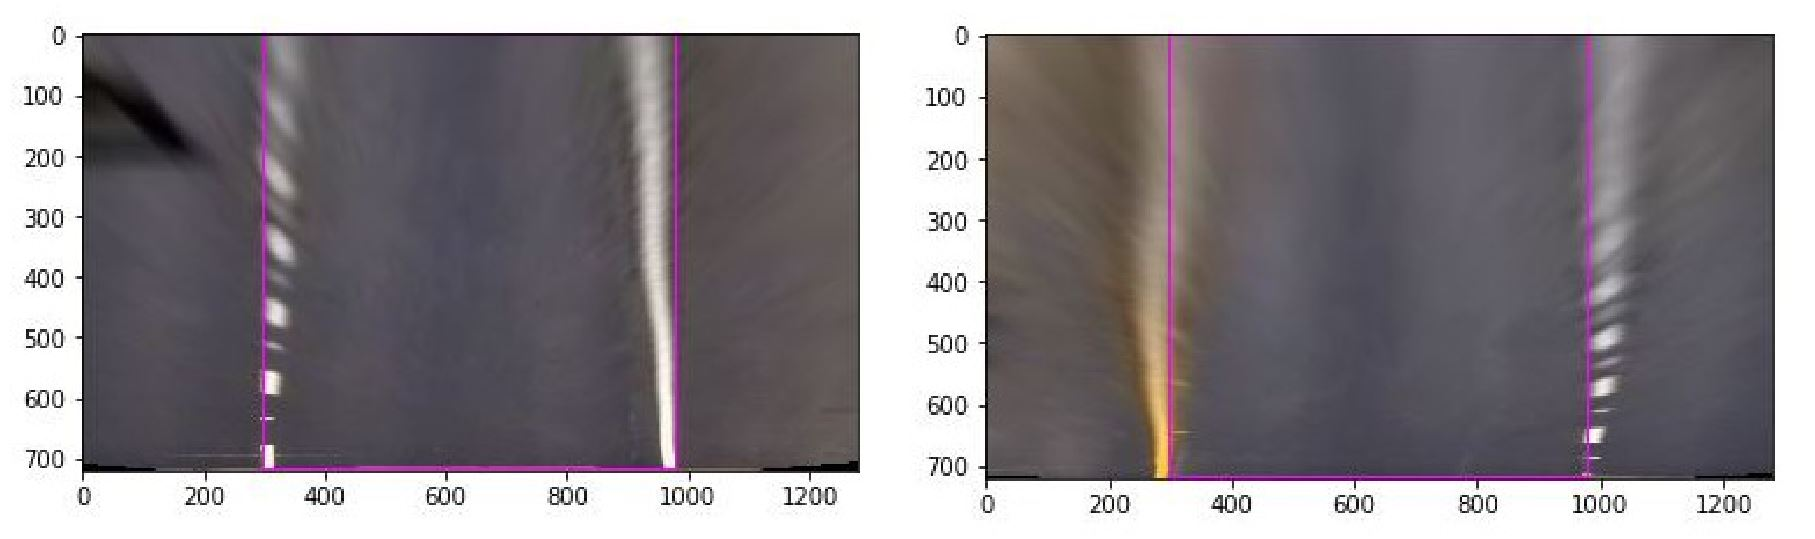

In [4]:
mtx, dist = distortion_factors()

def warp(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1], img.shape[0])
    offset = 300
    
    # Source points taken from images with straight lane lines, these are to become parallel after the warp transform
    src = np.float32([
        (190, 720), # bottom-left corner
        (596, 447), # top-left corner
        (685, 447), # top-right corner
        (1125, 720) # bottom-right corner
    ])
    # Destination points are to be parallel, taken into account the image size
    dst = np.float32([
        [offset, img_size[1]],             # bottom-left corner
        [offset, 0],                       # top-left corner
        [img_size[0]-offset, 0],           # top-right corner
        [img_size[0]-offset, img_size[1]]  # bottom-right corner
    ])
    # Calculate the transformation matrix and it's inverse transformation
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    return warped, M_inv # we will need M_inv for any plotting on original image

## Important pixels
The next step is to get important pixels and ignore others, important pixels are:
- vertical edges (Sobel)
- yellow pixles (Hue)
- saturated pixles (Sat)
- white pixles (pixle value)

The following code shows the output of each filter and the combined image.

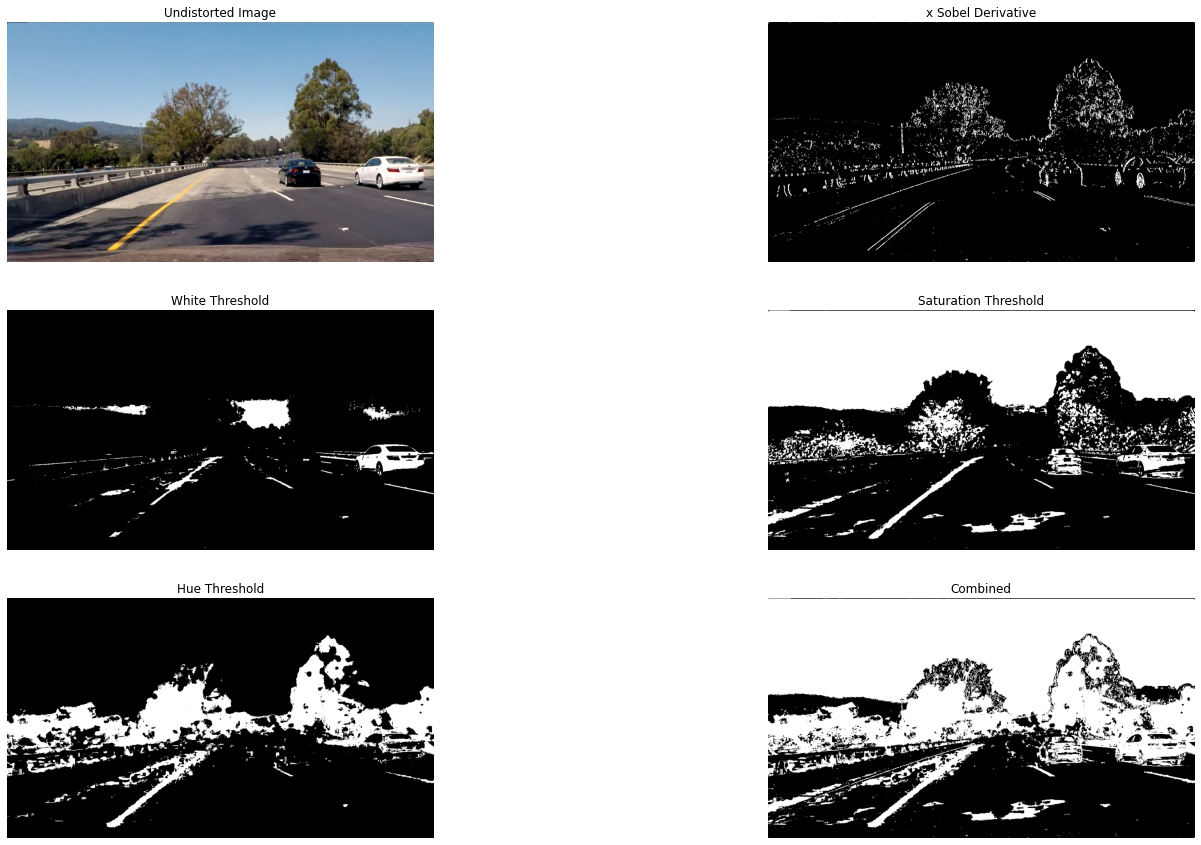

In [5]:
img = cv2.imread("test_images/test4.jpg")

def binary_thresholded(img, plot=False):
    # Transform image to gray scale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply sobel (derivative) in x direction, this is usefull to detect lines that tend to be vertical
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    # Scale result to 0-255
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sx_binary = np.zeros_like(scaled_sobel)
    # Keep only derivative values that are in the margin of interest
    sx_binary[(scaled_sobel >= 30) & (scaled_sobel <= 255)] = 1

    # Detect pixels that are white in the grayscale image
    white_binary = np.zeros_like(gray_img)
    white_binary[(gray_img > 200) & (gray_img <= 255)] = 1

    # Convert image to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    S = hls[:,:,2]
    sat_binary = np.zeros_like(S)
    # Detect pixels that have a high saturation value
    sat_binary[(S > 90) & (S <= 255)] = 1

    hue_binary =  np.zeros_like(H)
    # Detect pixels that are yellow using the hue component
    hue_binary[(H > 15) & (H <= 30)] = 1

    # Combine all pixels detected above
    binary_1 = cv2.bitwise_or(sx_binary, white_binary)
    binary_2 = cv2.bitwise_or(hue_binary, sat_binary)
    binary = cv2.bitwise_or(binary_1, binary_2)
    
    if plot:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Draw figure for binary images
        f, axarr = plt.subplots(3,2)
        f.set_size_inches(25, 15)
        axarr[0][0].imshow(img)
        axarr[0][1].imshow(sx_binary, cmap='gray')
        axarr[1][0].imshow(white_binary, cmap='gray')
        axarr[1][1].imshow(sat_binary, cmap='gray')
        axarr[2][0].imshow(hue_binary, cmap='gray')
        axarr[2][1].imshow(binary, cmap='gray')
        axarr[0][0].set_title("Undistorted Image")
        axarr[0][1].set_title("x Sobel Derivative")
        axarr[1][0].set_title("White Threshold")
        axarr[1][1].set_title("Saturation Threshold")
        axarr[2][0].set_title("Hue Threshold")
        axarr[2][1].set_title("Combined")
        axarr[0][0].axis('off')
        axarr[0][1].axis('off')
        axarr[1][0].axis('off')
        axarr[1][1].axis('off')
        axarr[2][0].axis('off')
        axarr[2][1].axis('off')
    
    return binary

out_img = binary_thresholded(img, True)

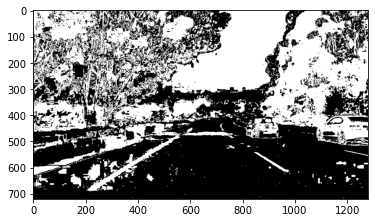

In [6]:
img = cv2.imread('test_images/test5.jpg')

binary_thresh = binary_thresholded(img)
out_img = np.dstack((binary_thresh, binary_thresh, binary_thresh))*255
binary_warped, M_inv = warp(binary_thresh)
plt.imshow(out_img, cmap='gray')

## Detecting lanes using histogram
We can now detect lanes by getting the first peak we find both on the left and right of the center of camera's perspective. since we weigh vertical edges, yellow and white colors highly this will means those will construct the peaks in the histogram.
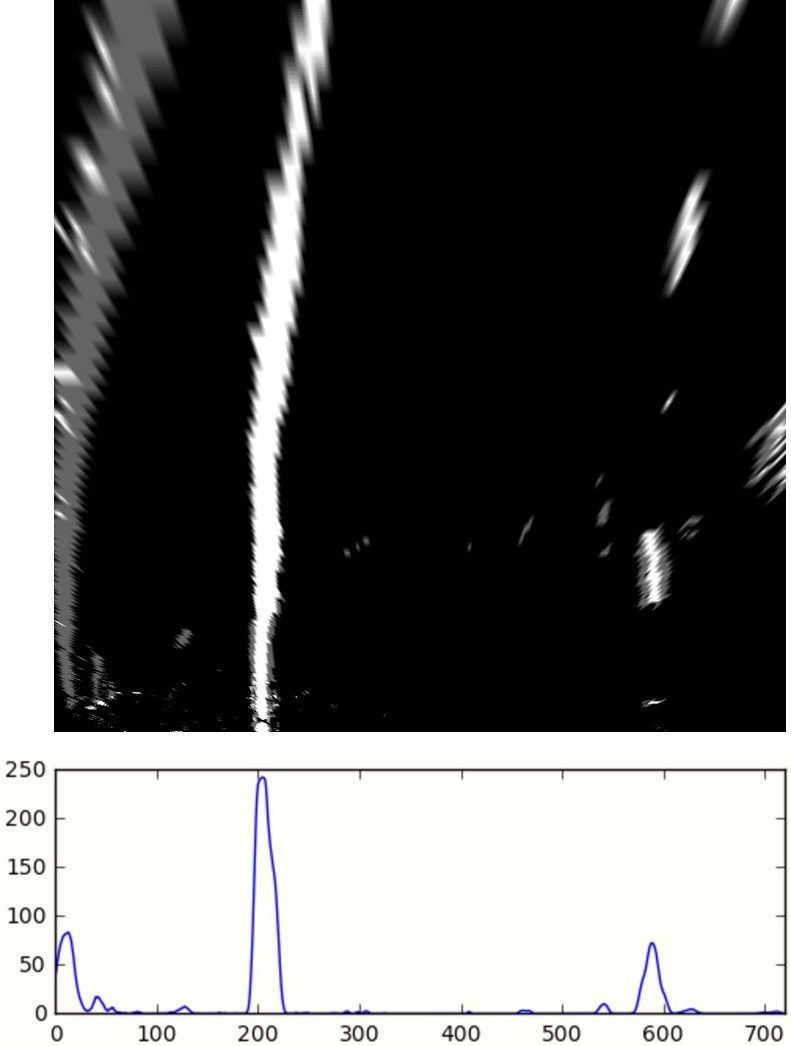

In [7]:
def find_lane_pixels_using_histogram(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = win_y_low + window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        else:
            histogram = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]//2)
            leftx_current = np.argmax(histogram[:midpoint])
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            histogram = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]//2)
            rightx_current = np.argmax(histogram[midpoint:]) + midpoint
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty





## Fit polynomial function to points
Having found a point per window that represents the lane, we need to connect those points using a second order polynomial, to model curvature. This we can do using the `np.polyfit` function.

[ 2.90084108e-04 -4.50287535e-01  4.47669669e+02]
prev left fit:  [ 2.90084108e-04 -4.50287535e-01  4.47669669e+02]
prev right fit:  [ 1.23113866e-03 -1.19592797e+00  1.26977839e+03]


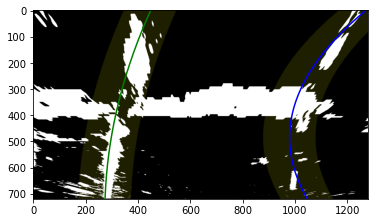

In [8]:
def fit_poly(binary_warped,leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)   
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty


def draw_poly_lines(binary_warped, left_fitx, right_fitx, ploty):     
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
        
    margin = 100
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (100, 100, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (100, 100, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='green')
    plt.plot(right_fitx, ploty, color='blue')
    ## End visualization steps ##
    return result
    
leftx, lefty, rightx, righty = find_lane_pixels_using_histogram(binary_warped)
left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty)
print(left_fit)
out_img = draw_poly_lines(binary_warped, left_fitx, right_fitx, ploty)
plt.imshow(out_img)

prev_left_fit, prev_right_fit = left_fit, right_fit
print('prev left fit: ', prev_left_fit)
print('prev right fit: ', prev_right_fit)


## Find lane pixels
having those two polynomials, we can get the lane pixels by shadowing what's between them.

(3,) (52579,) (720,) (720,)


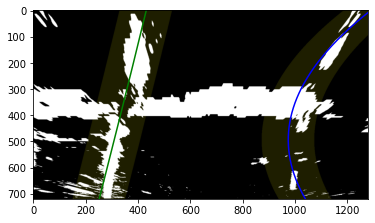

In [9]:
def find_lane_pixels_using_prev_poly(binary_warped):
    global prev_left_fit
    global prev_right_fit
    # width of the margin around the previous polynomial to search
    margin = 100
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + 
                    prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + 
                    prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))).nonzero()[0]
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + 
                    prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + 
                    prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin))).nonzero()[0]
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


leftx, lefty, rightx, righty = find_lane_pixels_using_prev_poly(binary_warped)
left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty)
out_img = draw_poly_lines(binary_warped, left_fitx, right_fitx, ploty)
print(left_fit.shape, leftx.shape, left_fitx.shape, ploty.shape)
plt.imshow(out_img)

## Measuring Metrics
Now that we have the polynomial functions, we can calculate the curvature of the lane. We measure the curvature from the car's perspective (which is the bottom of the image)

In [10]:
def measure_curvature_meters(binary_warped, left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def measure_position_meters(binary_warped, left_fit, right_fit):
    # Define conversion in x from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Choose the y value corresponding to the bottom of the image
    y_max = binary_warped.shape[0]
    # Calculate left and right line positions at the bottom of the image
    left_x_pos = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_x_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2] 
    # Calculate the x position of the center of the lane 
    center_lanes_x_pos = (left_x_pos + right_x_pos)//2
    # Calculate the deviation between the center of the lane and the center of the picture
    # The car is assumed to be placed in the center of the picture
    # If the deviation is negative, the car is on the felt hand side of the center of the lane
    veh_pos = ((binary_warped.shape[1]//2) - center_lanes_x_pos) * xm_per_pix 
    return veh_pos

left_curverad, right_curverad =  measure_curvature_meters(binary_warped, left_fitx, right_fitx, ploty)
print('left curve radius in meters  = ', left_curverad)
print('right curve radius in meters = ', right_curverad)
veh_pos = measure_position_meters(binary_warped, left_fit, right_fit)
print('vehicle position relative to center  = ', veh_pos)


left curve radius in meters  =  16372.996382363774
right curve radius in meters =  128.76294464566385
vehicle position relative to center  =  -0.02642857142857143


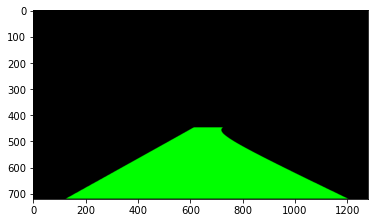

Text(0.5, 1.0, 'Image With Lane Marked')

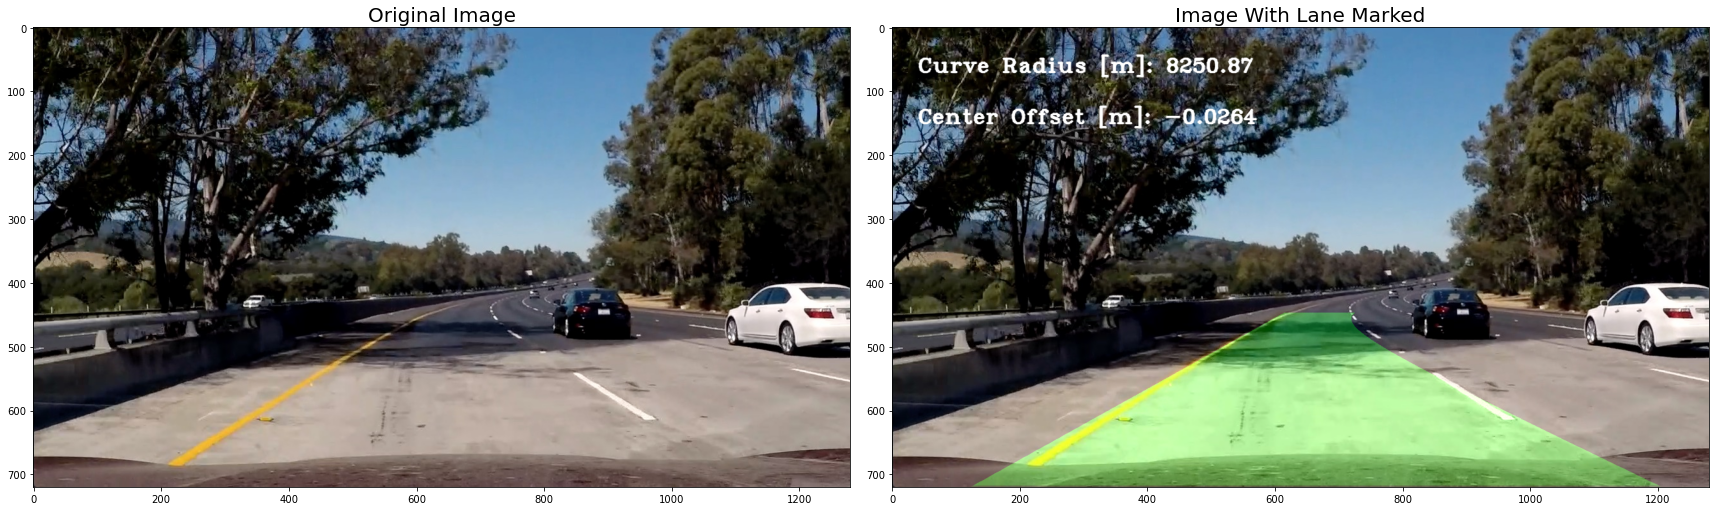

In [11]:
def project_lane_info(img, binary_warped, ploty, left_fitx, right_fitx, M_inv, left_curverad, right_curverad, veh_pos):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0]))
    
    # Combine the result with the original image
    out_img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    cv2.putText(out_img,'Curve Radius [m]: '+str((left_curverad+right_curverad)/2)[:7],(40,70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6, (255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img,'Center Offset [m]: '+str(veh_pos)[:7],(40,150), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6,(255,255,255),2,cv2.LINE_AA)
    
    return out_img, newwarp

new_img, newwarp = project_lane_info(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), binary_warped, ploty, left_fitx, right_fitx, M_inv, left_curverad, right_curverad, veh_pos)

plt.imshow(newwarp)
plt.show()

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(new_img, cmap='gray')
ax2.set_title('Image With Lane Marked', fontsize=20)


## Combine all in one pipeline

In [12]:
global left_fit_hist 
left_fit_hist = np.array([])

global right_fit_hist 
right_fit_hist = np.array([])

def lane_finding_pipeline(img):
    global left_fit_hist 
    global right_fit_hist
    global prev_left_fit
    global prev_right_fit
    binary_thresh = binary_thresholded(img)
    binary_warped, M_inv = warp(binary_thresh)
    #out_img = np.dstack((binary_thresh, binary_thresh, binary_thresh))*255
    if (len(left_fit_hist) == 0):
        leftx, lefty, rightx, righty = find_lane_pixels_using_histogram(binary_warped)
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty)
        # Store fit in history
        left_fit_hist = np.array(left_fit)
        new_left_fit = np.array(left_fit)
        left_fit_hist = np.vstack([left_fit_hist, new_left_fit])
        right_fit_hist = np.array(right_fit)
        new_right_fit = np.array(right_fit)
        right_fit_hist = np.vstack([right_fit_hist, new_right_fit])
    else:
        prev_left_fit = [np.mean(left_fit_hist[:,0]), np.mean(left_fit_hist[:,1]), np.mean(left_fit_hist[:,2])]
        prev_right_fit = [np.mean(right_fit_hist[:,0]), np.mean(right_fit_hist[:,1]), np.mean(right_fit_hist[:,2])]
        leftx, lefty, rightx, righty = find_lane_pixels_using_prev_poly(binary_warped)
        if (len(lefty) == 0 or len(righty) == 0):
            leftx, lefty, rightx, righty = find_lane_pixels_using_histogram(binary_warped)
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty)
        
        # Add new values to history
        new_left_fit = np.array(left_fit)
        left_fit_hist = np.vstack([left_fit_hist, new_left_fit])
        new_right_fit = np.array(right_fit)
        right_fit_hist = np.vstack([right_fit_hist, new_right_fit])
        
        # Remove old values from history
        if (len(left_fit_hist) > 10):
            left_fit_hist = np.delete(left_fit_hist, 0,0)
            right_fit_hist = np.delete(right_fit_hist, 0,0)
                                       
    left_curverad, right_curverad =  measure_curvature_meters(binary_warped, left_fitx, right_fitx, ploty)
                                     #measure_curvature_meters(binary_warped, left_fitx, right_fitx, ploty)
    veh_pos = measure_position_meters(binary_warped, left_fit, right_fit) 
    out_img, newwrap = project_lane_info(img, binary_warped, ploty, left_fitx, right_fitx, M_inv, left_curverad, right_curverad, veh_pos)
    return out_img




## Object Detection using YOLOv3
First we are going to define a couple of parameters
- config file
- weights file
- non-max supression threshold
- confidence threshold
We also need class names from the coco file, and for testing we are going to load any image

In [13]:
cfg_path = os.path.join("yolo", "yolov3.cfg")
weights_path = os.path.join("yolo", "yolov3.weights")
names_path = os.path.join("yolo", "coco.names")
test_image_path = os.path.join("test_images", "test1.jpg")
nms_thr = 0.5
confidence_thr = 0.6


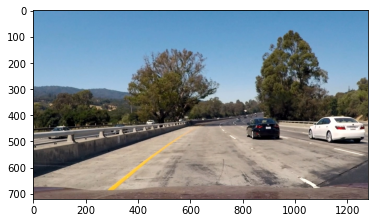

In [14]:
with open(names_path, "r") as fp:
    names = fp.read().strip().split("\n")
    
yolo = cv2.dnn.readNetFromDarknet(cfg_path, weights_path)
test_image = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
plt.imshow(test_image)

Then we create the blob object from the image and set it as the output of the loaded yolo network

In [15]:
H, W = test_image.shape[:2]
blob = cv2.dnn.blobFromImage(test_image, 1/255., (416, 416),
                            crop=False, swapRB=False)

In [16]:
yolo.setInput(blob)

In [17]:
## some helper functions for later

def get_output_layers(net):
    return list(net.getUnconnectedOutLayersNames())

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(names[class_id])

    color = (0, 255, 255)

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

### Get Bounding Boxes
In the following function we use the outputs of the yolo network to get the classes, confidences, and boxes of detected objects.  
We then return boxes that are above a certain threshold

In [18]:
def get_bounding_boxes(outs, W, H):
    # initialization
    class_ids = []
    confidences = []
    boxes = []

    # for each detetion from each output layer 
    # get the confidence, class id, bounding box params
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_thr:
                center_x = int(detection[0] * W)
                center_y = int(detection[1] * H)
                w = int(detection[2] * W)
                h = int(detection[3] * H)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])
    return class_ids, confidences, boxes

### Non-max Suppression
Multiple bounding boxes might detect the same object, this is why we use non-max suppression to get only one box per object.

In [19]:
def nms(img, class_ids, confidences, boxes):
    global confidence_thr, nms_thr
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_thr, nms_thr)

    # go through the detections remaining
    # after nms and draw bounding box
    for i in indices:
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]

        draw_bounding_box(img, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

In [20]:
def detection_pipeline(img):
    global yolo
    H, W = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, 1/255., (416, 416),
                            crop=False, swapRB=False)
    yolo.setInput(blob)
    outs = yolo.forward(get_output_layers(yolo))
    nms(img, *get_bounding_boxes(outs, W, H))
    return img


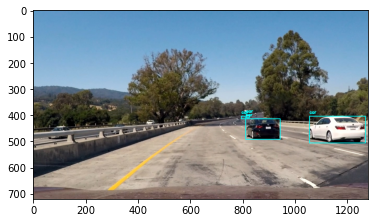

In [21]:
plt.imshow(detection_pipeline(test_image))

In [22]:
def combined_pipeline(img):
    img = lane_finding_pipeline(img)
    return detection_pipeline(img)

In [23]:
name = "project_video"
video_output = f"{name}_detection.mp4"
clip1 = VideoFileClip(f"{name}.mp4")
output_clip = clip1.fl_image(combined_pipeline)
%time output_clip.write_videofile(video_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_detection.mp4.
Moviepy - Writing video project_video_detection.mp4



Moviepy - Done !
Moviepy - video ready project_video_detection.mp4
CPU times: user 1h 12min 55s, sys: 3min 30s, total: 1h 16min 25s
Wall time: 13min 11s
